# Split Data
Notebook to work on train-validation split data strategies.

In [1]:
import os
from working_dir import set_wd
set_wd()
os.getcwd()

'/Users/tales.pimentel/ds/kaggle/football-match-prediction'

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("SplitData").getOrCreate()

In [3]:
import pyspark.sql.functions as f
import matplotlib.pyplot as plt

from src.dao import dao_raw, dao_interim,
from src.utils import dflib, stats, pretties, plot, palette

In [4]:
COLOR_TRAIN = palette.PALETTE_DATASETS["train"]
COLOR_TEST = palette.PALETTE_DATASETS["test"]
COLOR_VALID = palette.PALETTE_DATASETS["validation"]

In [5]:
pretties.max_data_frame_columns()

#### Predict the probabilities for each match outcome in the target columns: the probabilities of home to win, draw, and away to win.

In [6]:
train = dao_raw.load_parse_train_data(spark)
test = dao_raw.load_parse_test_data(spark)
scores = dao_raw.load_parse_scores_data(spark)

print(f"train: {dflib.shape(train)}")
print(f"test: {dflib.shape(test)}")
print(f"scores: {dflib.shape(scores)}")

train: (110938, 190)
test: (72711, 189)
scores: (110938, 3)


In [7]:
train = scores.select(["id", "score"]).join(train, on="id", how="inner")
print(f"train: {dflib.shape(train)}")

train: (110938, 191)


# Check built in Train-Test split

#### Checking whether a date splits both train and test datasets

In [8]:
train.limit(5).toPandas()

,id,score,target,home_team_name,away_team_name,match_date,league_name,league_id,is_cup,home_team_coach_id,away_team_coach_id,home_team_history_match_date_1,home_team_history_match_date_2,home_team_history_match_date_3,home_team_history_match_date_4,home_team_history_match_date_5,home_team_history_match_date_6,home_team_history_match_date_7,home_team_history_match_date_8,home_team_history_match_date_9,home_team_history_match_date_10,home_team_history_is_play_home_1,home_team_history_is_play_home_2,home_team_history_is_play_home_3,home_team_history_is_play_home_4,home_team_history_is_play_home_5,home_team_history_is_play_home_6,home_team_history_is_play_home_7,home_team_history_is_play_home_8,home_team_history_is_play_home_9,home_team_history_is_play_home_10,home_team_history_is_cup_1,home_team_history_is_cup_2,home_team_history_is_cup_3,home_team_history_is_cup_4,home_team_history_is_cup_5,home_team_history_is_cup_6,home_team_history_is_cup_7,home_team_history_is_cup_8,home_team_history_is_cup_9,home_team_history_is_cup_10,home_team_history_goal_1,home_team_history_goal_2,home_team_history_goal_3,home_team_history_goal_4,home_team_history_goal_5,home_team_history_goal_6,home_team_history_goal_7,home_team_history_goal_8,home_team_history_goal_9,home_team_history_goal_10,home_team_history_opponent_goal_1,home_team_history_opponent_goal_2,home_team_history_opponent_goal_3,home_team_history_opponent_goal_4,home_team_history_opponent_goal_5,home_team_history_opponent_goal_6,home_team_history_opponent_goal_7,home_team_history_opponent_goal_8,home_team_history_opponent_goal_9,home_team_history_opponent_goal_10,home_team_history_rating_1,home_team_history_rating_2,home_team_history_rating_3,home_team_history_rating_4,home_team_history_rating_5,home_team_history_rating_6,home_team_history_rating_7,home_team_history_rating_8,home_team_history_rating_9,home_team_history_rating_10,home_team_history_opponent_rating_1,home_team_history_opponent_rating_2,home_team_history_opponent_rating_3,home_team_history_opponent_rating_4,home_team_history_opponent_rating_5,home_team_history_opponent_rating_6,home_team_history_opponent_rating_7,home_team_history_opponent_rating_8,home_team_history_opponent_rating_9,home_team_history_opponent_rating_10,home_team_history_coach_1,home_team_history_coach_2,home_team_history_coach_3,home_team_history_coach_4,home_team_history_coach_5,home_team_history_coach_6,home_team_history_coach_7,home_team_history_coach_8,home_team_history_coach_9,home_team_history_coach_10,home_team_history_league_id_1,home_team_history_league_id_2,home_team_history_league_id_3,home_team_history_league_id_4,home_team_history_league_id_5,home_team_history_league_id_6,home_team_history_league_id_7,home_team_history_league_id_8,home_team_history_league_id_9,home_team_history_league_id_10,away_team_history_match_date_1,away_team_history_match_date_2,away_team_history_match_date_3,away_team_history_match_date_4,away_team_history_match_date_5,away_team_history_match_date_6,away_team_history_match_date_7,away_team_history_match_date_8,away_team_history_match_date_9,away_team_history_match_date_10,away_team_history_is_play_home_1,away_team_history_is_play_home_2,away_team_history_is_play_home_3,away_team_history_is_play_home_4,away_team_history_is_play_home_5,away_team_history_is_play_home_6,away_team_history_is_play_home_7,away_team_history_is_play_home_8,away_team_history_is_play_home_9,away_team_history_is_play_home_10,away_team_history_is_cup_1,away_team_history_is_cup_2,away_team_history_is_cup_3,away_team_history_is_cup_4,away_team_history_is_cup_5,away_team_history_is_cup_6,away_team_history_is_cup_7,away_team_history_is_cup_8,away_team_history_is_cup_9,away_team_history_is_cup_10,away_team_history_goal_1,away_team_history_goal_2,away_team_history_goal_3,away_team_history_goal_4,away_team_history_goal_5,away_team_history_goal_6,away_team_history_goal_7,away_team_history_goal_8,away_team_history_goal_9,away_team_history_goal_10,away_team_hi

In [9]:
print("train")
train.agg({"match_date": "min"}).join(train.agg({"match_date": "max"})).show()

print("test")
test.agg({"match_date": "min"}).join(test.agg({"match_date": "max"})).show()

train
+-------------------+-------------------+
|    min(match_date)|    max(match_date)|
+-------------------+-------------------+
|2019-12-01 00:45:00|2021-05-01 00:00:00|
+-------------------+-------------------+

test
+-------------------+-------------------+
|    min(match_date)|    max(match_date)|
+-------------------+-------------------+
|2021-05-01 00:15:00|2021-11-30 23:30:00|
+-------------------+-------------------+



#### Checking the match frequency over time

In [10]:
train_count_per_week = train.groupBy(f.date_trunc("week", "match_date").alias("week")).count().sort("week")
print(f"train: {train_count_per_week.count()} weeks")

test_count_per_week = test.groupBy(f.date_trunc("week", "match_date").alias("week")).count().sort("week")
print(f"test:  {test_count_per_week.count()} weeks")

train: 73 weeks
test:  32 weeks


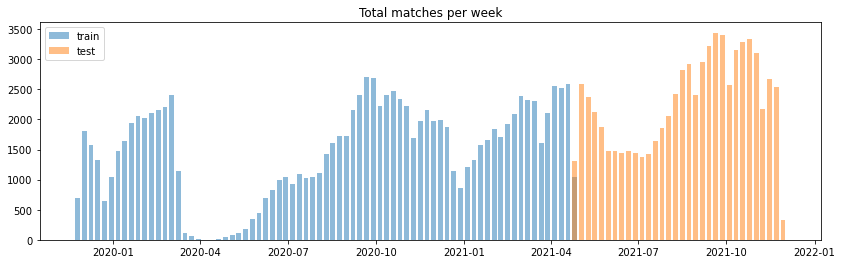

,count,relative_freq
partition,,
train,110938,0.6041
test,72711,0.3959


In [11]:
plot.bar_multi(df_list=[train_count_per_week, test_count_per_week], 
               x="week", y="count", legend_list=["train", "test"], title="Total matches per week", 
               alpha=0.5, color_list=[COLOR_TRAIN, COLOR_TEST], figsize=(14,4))

#### Checking values presence in both partitions

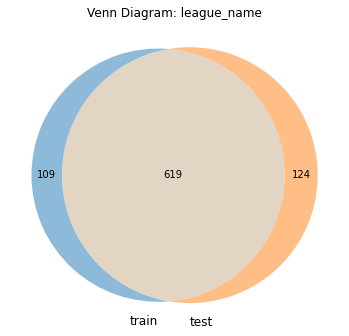

,train exclusive,intersection,test exclusive
relative_freq,0.1279,0.7265,0.1455


In [19]:
plot.venn(train, test, on_colnames="league_name", labels=["train", "test"], title="Venn Diagram: league_name",
          colors=[COLOR_TRAIN, COLOR_TEST], alpha=0.5, figsize=(6,6))

# Train and Validation split

In [13]:
train_count_per_week_cumsum = stats.cum_sum(df=train_count_per_week, 
                                            colname="count", 
                                            order_by="week")

In [14]:
split_threshold = 0.80

proposed_train_count_per_week_cumsum = train_count_per_week_cumsum.filter(f.col("cumsum_rel(count)") <= split_threshold)
proposed_valid_count_per_week_cumsum = train_count_per_week_cumsum.filter(f.col("cumsum_rel(count)") > split_threshold)

max_week_train = proposed_train_count_per_week_cumsum.agg({"week": "max"}).collect()[0]["max(week)"].strftime("%Y-%m-%d")
min_week_valid = proposed_valid_count_per_week_cumsum.agg({"week": "min"}).collect()[0]["min(week)"].strftime("%Y-%m-%d")

proposed_train = train.filter(train["match_date"] < min_week_valid)
proposed_valid = train.filter(train["match_date"] >= min_week_valid)

print(f"max_week_train: {max_week_train}")
print(f"min_week_valid: {min_week_valid}")
print()
print(f"proposed_train: {dflib.shape(proposed_train)}")
print(f"proposed_valid: {dflib.shape(proposed_valid)}")

max_week_train: 2021-02-08
min_week_valid: 2021-02-15

proposed_train: (87470, 191)
proposed_valid: (23468, 191)


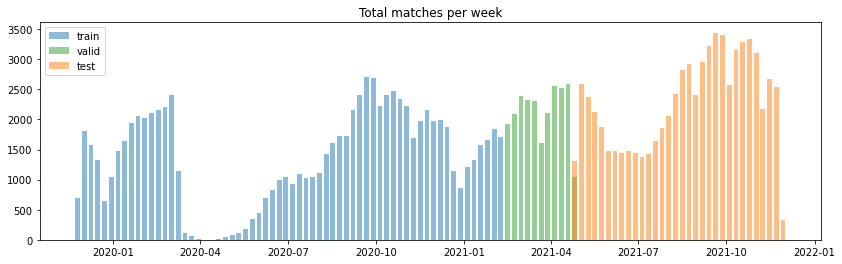

,count,relative_freq
partition,,
train,87470,0.4763
valid,23468,0.1278
test,72711,0.3959


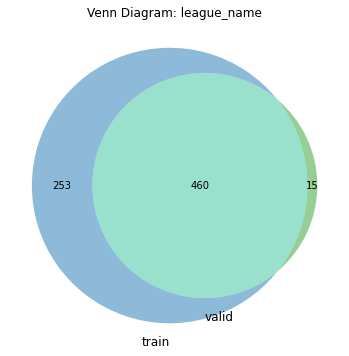

,train exclusive,intersection,valid exclusive
relative_freq,0.3475,0.6319,0.0206


In [18]:
plot.bar_multi(df_list=[proposed_train_count_per_week_cumsum, proposed_valid_count_per_week_cumsum, test_count_per_week], 
               x="week", y="count", legend_list=["train", "valid", "test"], title="Total matches per week", 
               alpha=0.5, color_list=[COLOR_TRAIN, COLOR_VALID, COLOR_TEST], figsize=(14,4))
pretties.hr()
plot.venn(proposed_train, proposed_valid, on_colnames="league_name", labels=["train", "valid"], 
          title="Venn Diagram: league_name", colors=[COLOR_TRAIN, COLOR_VALID], alpha=0.5, figsize=(6,6))

# Split Threshold

The validation partition have 20% most recent matches of train dataset. <br>
Considering the whole data available, originals train.csv and test.csv, the proportion of each dataset are:
 * train: 47.6%
 * validation: 12.8%
 * test: 39.6%
 
One interesting thing to hilight is that the validation dataset contains less 'unknown' `league_name` than test dataset. Depending on how the features selected and built, it may contribute for even better results in validation metrics. 

In [16]:
dao_interim.save_train_train_ids(proposed_train.select("id"))
dao_interim.save_train_valid_ids(proposed_valid.select("id"))